<font size=8> Network Tests


In [1]:
#Common Python Packages
from pickle import TRUE
import pickle
import os
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

#dynapse2 spikegen imports
from lib.dynapse2_util import *
from lib.dynapse2_network import Network
from lib.dynapse2_raster import *
from lib.dynapse2_obj import *
from lib.dynapse2_raster import *

#Statistics imports
from scipy.optimize import curve_fit
from scipy.signal import savgol_filter
from scipy.signal import butter, filtfilt
from sklearn.linear_model import LinearRegression
from scipy.stats import linregress
from itertools import product

#my imports
from adaptation import pc_single,ff,pc_pv_sst,ff_network
from adaptation_lib.spike_stats import *
from adaptation_lib.dynapse_setup import *
from adaptation_lib.graphing import *
from configs import neuron_configs_bio

# Determine the user's home directory
home_directory = os.path.expanduser("~")
# Path to the Documents directory
documents_path = os.path.join(home_directory, "Documents")
# Path to the dynapse-se2-data directory within Documents
save_directory_path = os.path.join(documents_path, "dynapse-se2-data")
# Path to the data
data_type_path = os.path.join(save_directory_path, "network_heatmaps")

In [2]:
neuron_config=neuron_configs_bio.config()
#remove SST connections to focus in th eEI balance structure
neuron_config['Input_SST']=0
neuron_config['PC_SST']=0
neuron_config['PC_Adaptation']=True


<font size=8> Heatmaps Plotting

In [41]:
def plot_heatmaps(data_path,xlabel):
    # Load data
    data = np.load(data_path, allow_pickle=True).item()
    
    # Extract data for plotting
    cv_values_pc = data['cv_values_pc']
    synchrony_values_pc = data['synchrony_values_pc']
    mean_pc_rates = data['mean_pc_rates']
    input_frequencies = data['input_frequencies']
    connection_ratios = data['connection_ratios']
    
    # Reshape the flat lists into 2D arrays
    cv_matrix = np.reshape(cv_values_pc, (len(input_frequencies), len(connection_ratios)))
    synchrony_matrix = np.reshape(synchrony_values_pc, (len(input_frequencies), len(connection_ratios)))
    mean_rates_matrix = np.reshape(mean_pc_rates, (len(input_frequencies), len(connection_ratios)))
    
    # Flip the matrices vertically so the lowest frequencies are at the bottom
    cv_matrix = np.flipud(cv_matrix)
    synchrony_matrix = np.flipud(synchrony_matrix)
    mean_rates_matrix = np.flipud(mean_rates_matrix)
    
    # Create a 1x3 subplot for the heatmaps with a more square-like figure size
    fig, axes = plt.subplots(1, 3, figsize=(15, 5), constrained_layout=True)
    
    # Titles for each subplot
    titles = ['CV Values (PC)', 'Synchrony Values (PC)', 'Mean Firing Rates (PC)']
    
    # Plot each heatmap with aspect='auto' to allow each heatmap to fill the space of the subplot axes
    for ax, matrix, title in zip(axes, [cv_matrix, synchrony_matrix, mean_rates_matrix], titles):
        cax = ax.matshow(matrix, interpolation='nearest', aspect='auto')
        fig.colorbar(cax, ax=ax)
        ax.xaxis.set_ticks_position('bottom')
        ax.set_xticks(np.linspace(0, len(connection_ratios) - 1, min(5, len(connection_ratios))))
        ax.set_xticklabels(np.round(np.linspace(connection_ratios[0], connection_ratios[-1], min(5, len(connection_ratios))), 2))
        ax.set_yticks(np.linspace(0, len(input_frequencies) - 1, min(5, len(input_frequencies))))
        ax.set_yticklabels(np.round(np.linspace(input_frequencies[0], input_frequencies[-1], min(5, len(input_frequencies)))[::-1], 2))
        ax.set_title(title)
    
    # Set y-label on the first subplot and x-labels on all
    axes[0].set_ylabel('Input Frequencies')
    for ax in axes:
        ax.set_xlabel(xlabel)
    
    # Display the plot
    plt.show()

<font size=6> Regular Input

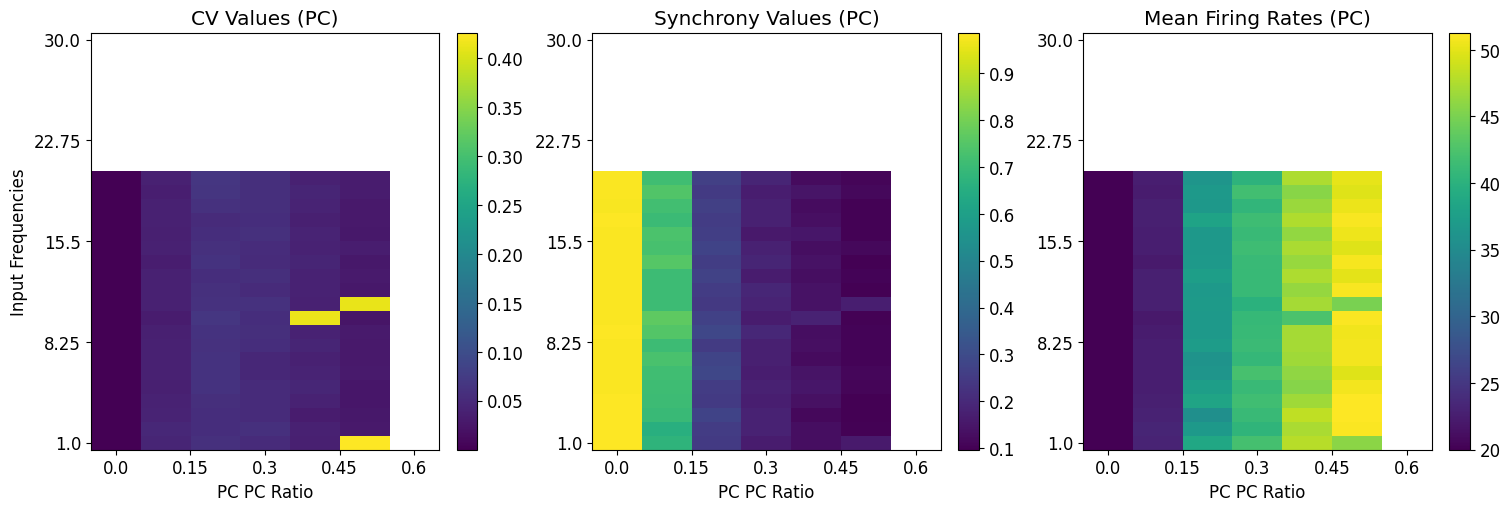

In [44]:
data_path_1 = os.path.join(data_type_path, "EE_sweep_regular.npy")
plot_heatmaps(data_path_1, 'PC PC Ratio')


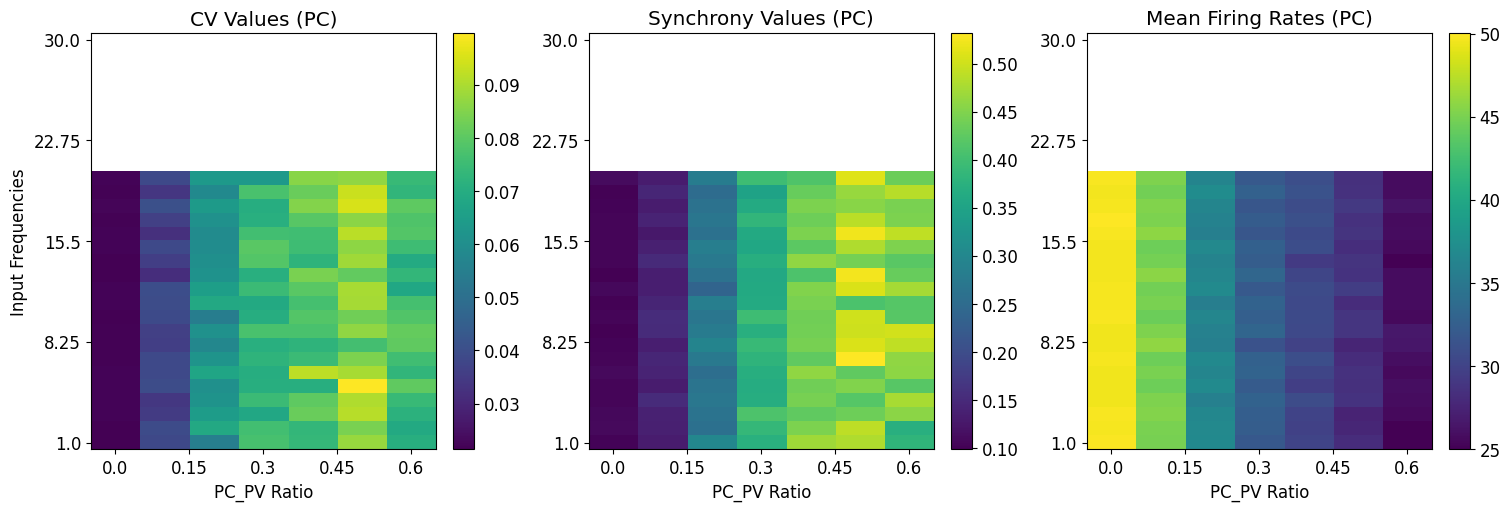

In [45]:
data_path_2 = os.path.join(data_type_path, "EI_sweep_regular.npy")
plot_heatmaps(data_path_2, 'PC_PV Ratio')



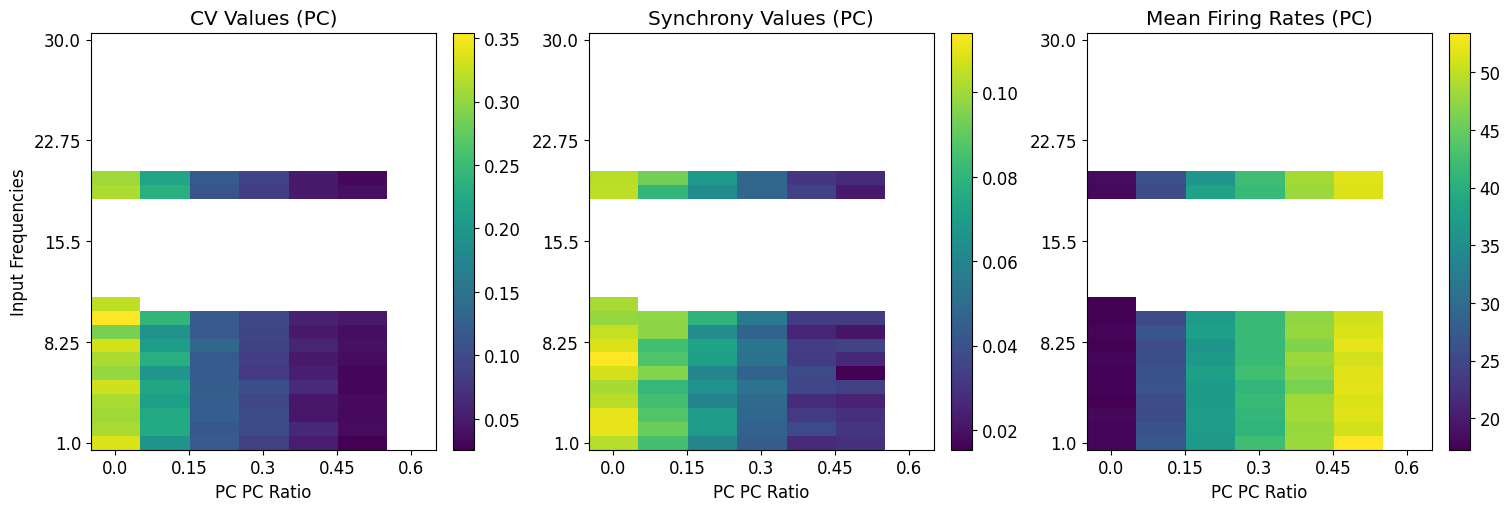

In [49]:
data_path_3 = os.path.join(data_type_path, "EE_sweep_poisson.npy")
plot_heatmaps(data_path_3, 'PC PC Ratio')


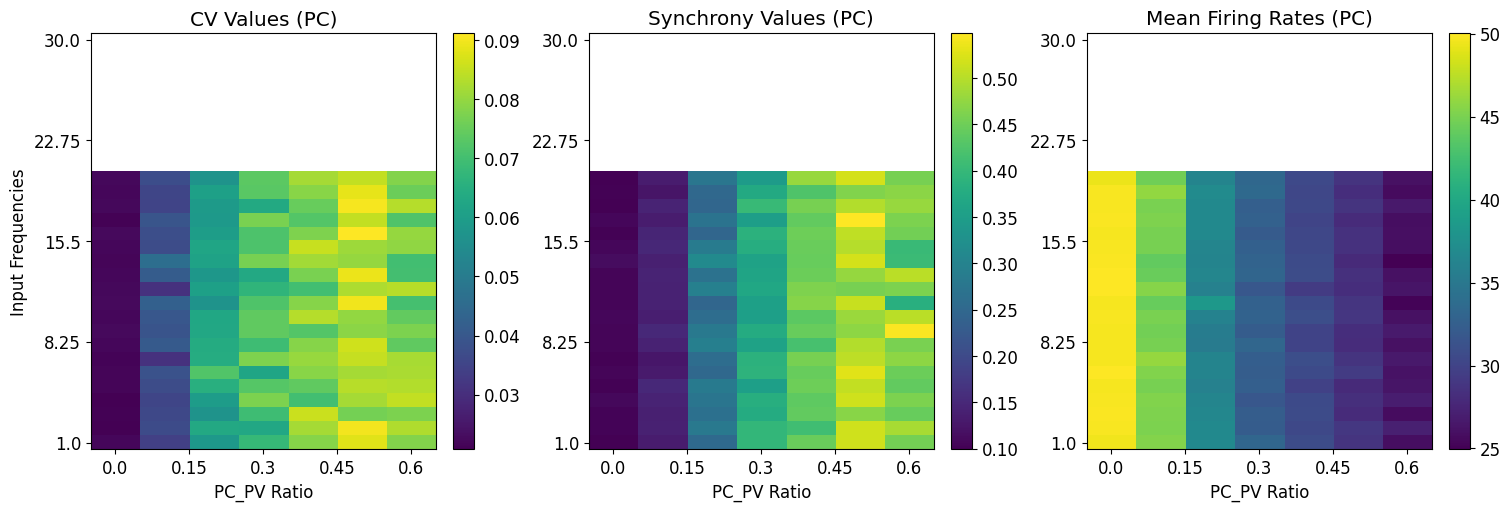

In [48]:
data_path_4 = os.path.join(data_type_path, "EI_sweep_poisson.npy")
plot_heatmaps(data_path_4, 'PC_PV Ratio')


<font size=6> combined visualization

In [95]:
import numpy as np
import matplotlib.pyplot as plt

def plot_combined_heatmaps(data_dicts, xlabels, ytitles, tick_fontsize=10, title_fontsize=12, label_fontsize=10, colorbar_size=0.046, row_spacing=0.04):
    # Set the figure and axes for the subplots
    fig, axes = plt.subplots(4, 3, figsize=(15, 18), constrained_layout=True)

    # Adjust spacing between rows if needed
    plt.subplots_adjust(hspace=row_spacing)

    # Titles for each column
    col_titles = ['CV Values', 'Synchrony Values', 'Mean Firing Rates']
    
    # Set subplot titles and axis labels
    for i in range(4):
        for j in range(3):
            ax = axes[i, j]
            if i == 0:  # Set column titles for the first row
                ax.set_title(col_titles[j], fontsize=title_fontsize)
            ax.set_xlabel(xlabels[i], fontsize=label_fontsize, labelpad=10)  # Set x-axis labels for every row based on the row index
            if j == 0:  # Set y-axis labels for the first column
                ax.set_ylabel('Input Frequencies', fontsize=label_fontsize, labelpad=10)

    # Set larger y-axis titles for the first two and last two rows
    fig.text(-0.04, 0.75, ytitles[0], va='center', ha='center', rotation='vertical', fontsize=title_fontsize)
    fig.text(-0.04, 0.25, ytitles[1], va='center', ha='center', rotation='vertical', fontsize=title_fontsize)

    # Plot heatmaps for each data dictionary
    for i, data in enumerate(data_dicts):
        # Set the ticks for the x axis (same for each row)
        xticks = np.linspace(0, len(data['connection_ratios']) - 1, min(5, len(data['connection_ratios'])))
        xticklabels = np.round(np.linspace(data['connection_ratios'][0], data['connection_ratios'][-1], min(5, len(data['connection_ratios']))), 2)
        
        # Prepare data matrices
        matrices = [np.flipud(np.reshape(data[key], (len(data['input_frequencies']), len(data['connection_ratios'])))) for key in ['cv_values_pc', 'synchrony_values_pc', 'mean_pc_rates']]
        
        # Plot heatmaps
        for j, matrix in enumerate(matrices):
            ax = axes[i, j]
            cax = ax.matshow(matrix, interpolation='nearest', aspect='auto')
            # Add colorbars, adjusted if necessary
            fig.colorbar(cax, ax=ax, fraction=colorbar_size, pad=0.04)
            # Set the ticks for the x axis
            ax.xaxis.set_ticks_position('bottom')
            ax.set_xticks(xticks)
            ax.set_xticklabels(xticklabels, fontsize=tick_fontsize)
            # Set the ticks for the y axis
            yticks = np.linspace(0, len(data['input_frequencies']) - 1, min(5, len(data['input_frequencies'])))
            yticklabels = np.round(np.linspace(data['input_frequencies'][0], data['input_frequencies'][-1], min(5, len(data['input_frequencies'])))[::-1]).astype(int)
            ax.set_yticks(yticks)
            ax.set_yticklabels(yticklabels, fontsize=tick_fontsize)

    # Display the plot
    plt.show()

# Example usage:
# data_dicts = [data1, data2, data3, data4]
# xlabels = ['X-Label 1', 'X-Label 2', 'X-Label 3', 'X-Label 4']
# ytitles = ['Y-Title for Rows 1-2', 'Y-Title for Rows 3-4']
# plot_combined_heatmaps(data_dicts, xlabels, ytitles, tick_fontsize=10, title_fontsize=12, label_fontsize=10, colorbar_size=0.05, row_spacing=0.05)


data_1=np.load

/tmp/ipykernel_86335/1149986630.py:9: UserWarning: This figure was using a layout engine that is incompatible with subplots_adjust and/or tight_layout; not calling subplots_adjust.
  plt.subplots_adjust(hspace=row_spacing)


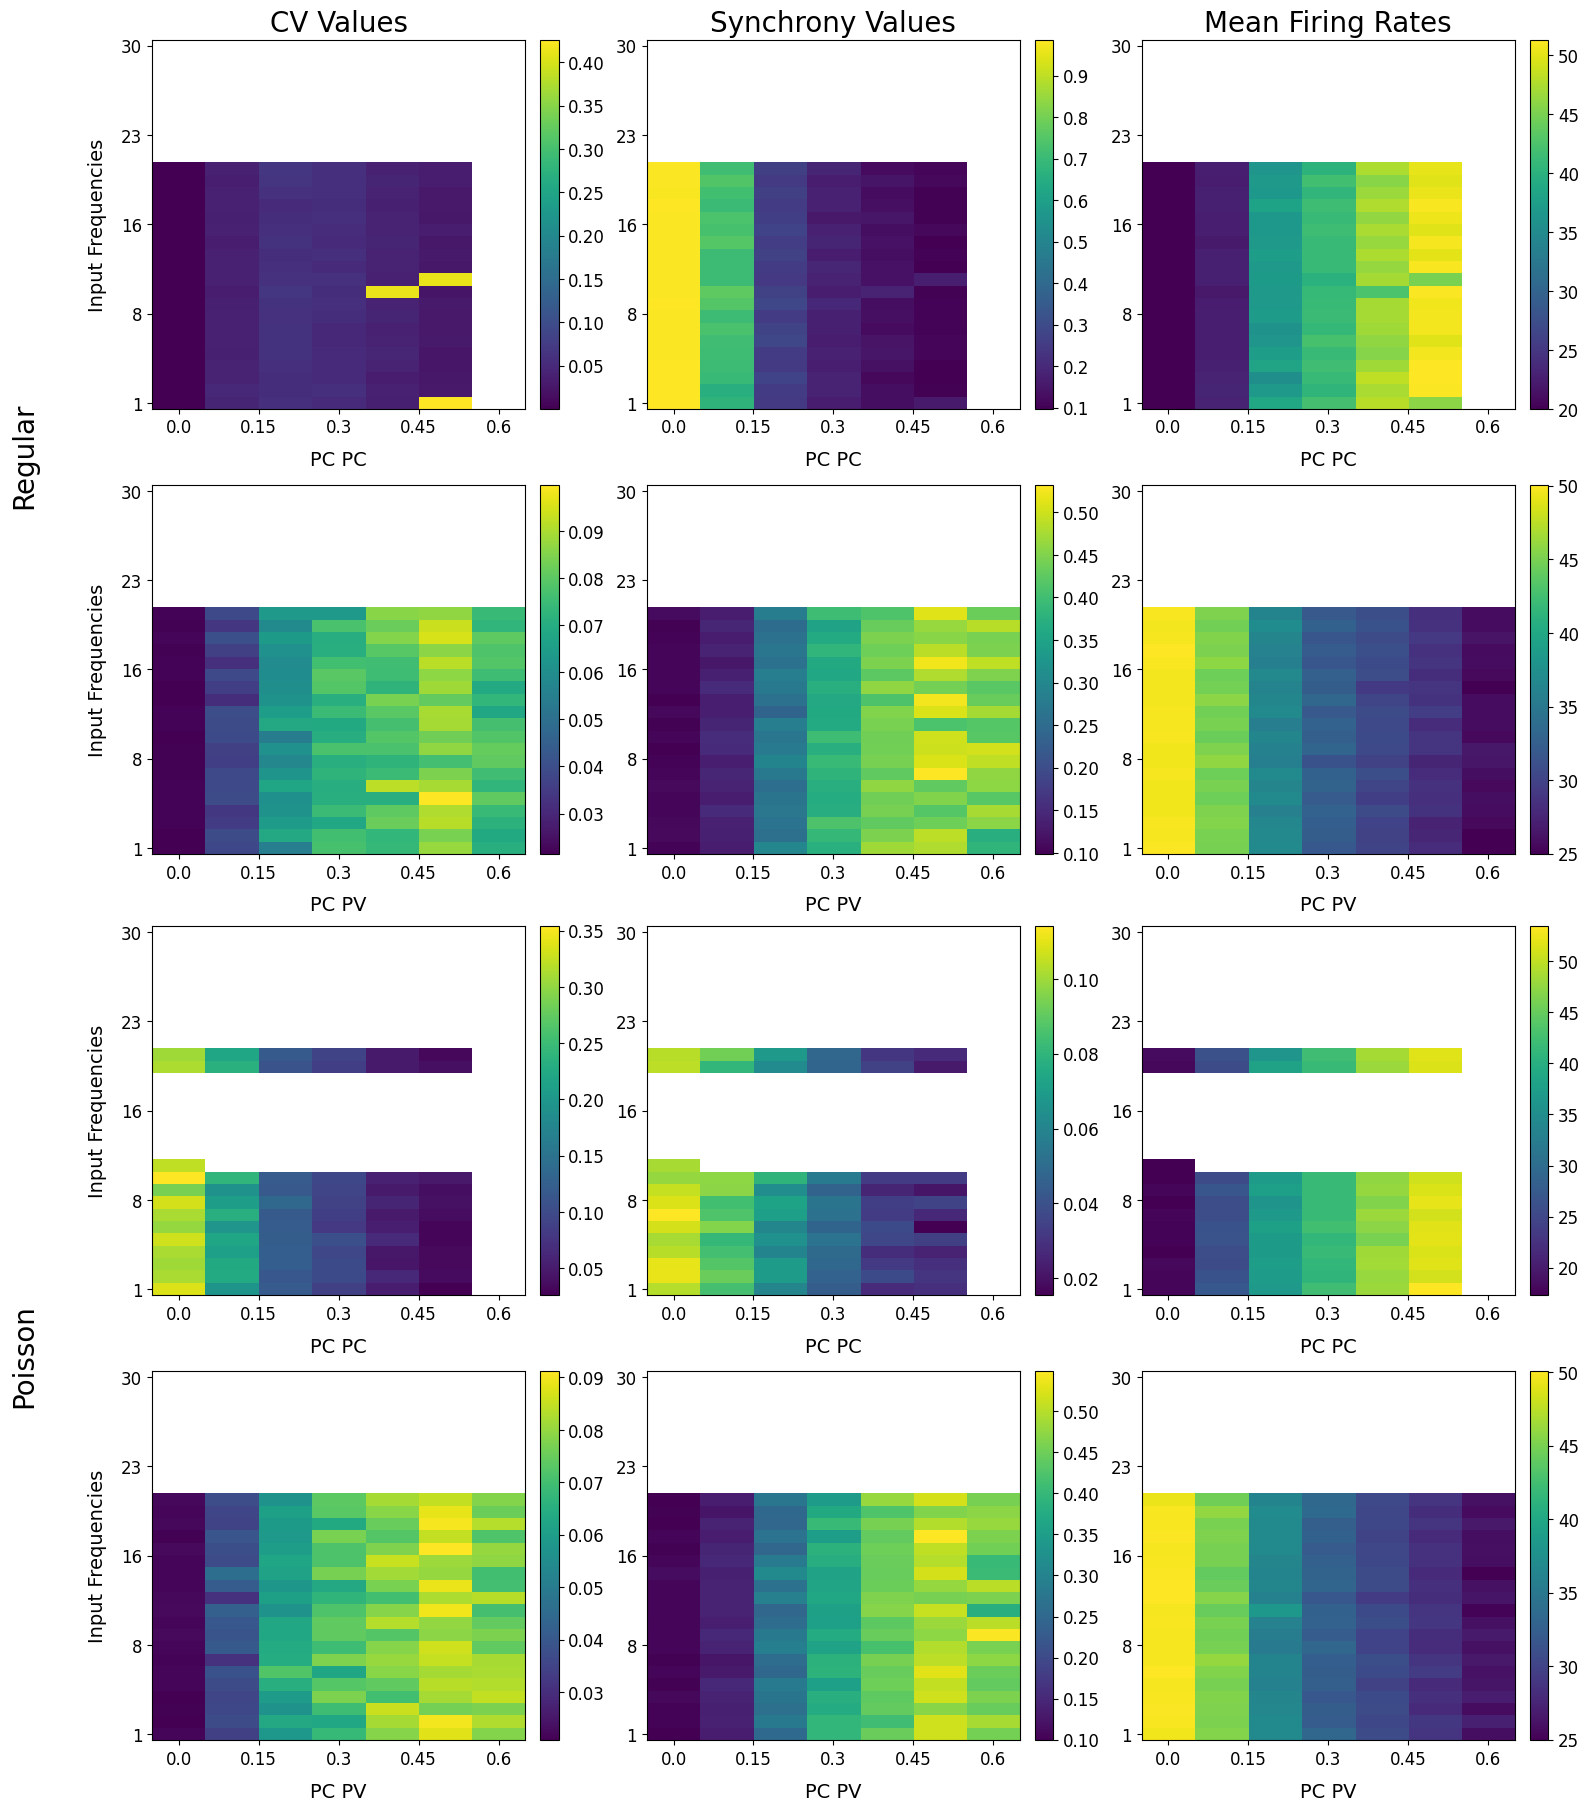

In [98]:
data_1=np.load(data_path_1, allow_pickle=True).item()
data_2=np.load(data_path_2, allow_pickle=True).item()
data_3=np.load(data_path_3, allow_pickle=True).item()
data_4=np.load(data_path_4, allow_pickle=True).item()
data_dicts = [data_1, data_2, data_3, data_4]
xlabels = ['PC PC', 'PC PV', 'PC PC', 'PC PV']
ytitles = ['Regular', 'Poisson']
plot_combined_heatmaps(data_dicts, xlabels, ytitles, tick_fontsize=12, title_fontsize=20, label_fontsize=14, colorbar_size=0.05, row_spacing=0.20)
